In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

#import the noise packages
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error,amplitude_damping_error,phase_damping_error,phase_amplitude_damping_error
from qiskit.providers.aer.noise import thermal_relaxation_error


from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_noise(p_bit,p_phase,p_gate1,p_gate2):
    bit_flip = pauli_error([('X',p_bit), ('I', 1 - p_bit)])#bit flip
    phase_flip = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])#phase flip
    #bitphase_flip = phase_flip.compose(phase_flip)
    #error_gate1 = depolarizing_error(p_gate, 1)
    #error_gate2=amplitude_damping_error(p_gate, excited_state_population=0, canonical_kraus=True)
    #error_gate3=phase_damping_error(p_gate, canonical_kraus=True)
    error_gate4=phase_amplitude_damping_error(p_gate1, p_gate2, excited_state_population=0, canonical_kraus=True)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(phase_flip, "measure") # measurement error is applied to measurements
    #noise_model.add_all_qubit_quantum_error(error_gate4, ["x","h"]) # single qubit gate error is applied to x gates
        
    return noise_model


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


In [ ]:
#Give the proper parameter
noise_model = get_noise(0.05,0.05,0.05,0.05)  

In [3]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [56]:
quantum_instance2 = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024, noise_model=noise_model)

In [4]:
# callback function that draws a live plot when the .fit() method is called

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

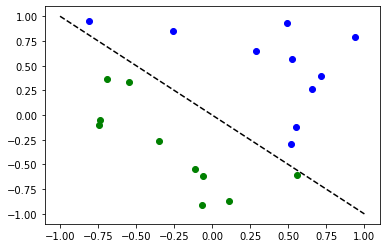

In [5]:
#We prepare a simple classification dataset to illustrate the following algorithms.

num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [44]:
from sklearn import datasets
from sklearn.decomposition import PCA


iris = datasets.load_iris()
x = iris.data
y = iris.target


X = np.concatenate((x[:40], x[50:90]))


y_one_hot = np.array([[1,0]])
for i in range(39):
  y_one_hot = np.concatenate((y_one_hot, [[1,0]]))

for i in range(40):
  y_one_hot = np.concatenate((y_one_hot, [[0,1]]))

In [57]:
# construct feature map, ansatz, and optimizer

num_inputs = 4

#num_samples = 20

feature_map = ZZFeatureMap(num_inputs, reps=2)

ansatz = RealAmplitudes(num_inputs, reps=2, entanglement='full')

In [58]:
# construct variational quantum classifier

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=1000, tol=0.001),
    quantum_instance=quantum_instance2,
    callback=callback_graph,
)

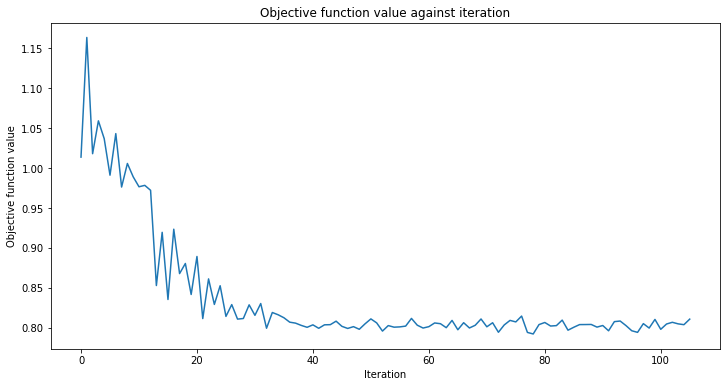

0.7875

In [59]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

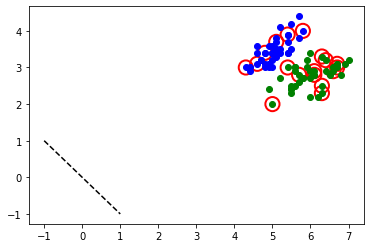

In [60]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()